In [1]:
%matplotlib inline
import pyfolio as pf

In [2]:
import zipline
from zipline.api import *
from zipline.utils.events import BeforeClose
from zipline.utils.run_algo import run_algorithm
from datetime import datetime, timedelta
import pytz
import pandas as pd
import pandas_datareader.data as web

In [3]:
!zipline bundles

quandl <no ingestions>
quantopian-quandl 2017-09-27 10:45:08.190035


In [4]:
candles = 3
ticker = 'SPY'
from_date = datetime(2000,1,1, tzinfo=pytz.utc)
to_date = datetime(2014,1,1, tzinfo=pytz.utc)
capital_base = 10000

In [5]:
def initialize(context):
    context.i = 0
    context.asset = symbol(ticker)
    schedule_function(func=handle_data_eod,
                      #date_rules=date_rules.every_day(),
                      time_rule=time_rules.market_close(minutes=5),
                      calendar=calendars.US_EQUITIES)

def handle_data(context, data):
    pass
    
def handle_data_eod(context, data):
    context.i += 1
    if context.i < candles:
        return

    #always close previous day
    order_target_percent(context.asset, 0)

    hist = data.history(context.asset, 
                           ('open', 'high', 'low', 'close'), 
                           bar_count=candles, 
                           frequency="1d")
    current_candle = hist.iloc[-1]
    
    all_negative = ((hist['close'] - hist['open']) < 0).all()
    if all_negative:
        #current_candle = hist.iloc[-1]
        lower_bound = current_candle['low'] + (current_candle['high']-current_candle['low'])*0.75
        if current_candle['close'] > lower_bound:
            print('==========\n{}\n'.format(context.datetime))
            print(hist)
            print('\ncurrent:')
            print(data.current(context.asset, ('open', 'high', 'low', 'close')))
            order_target_percent(context.asset, 5)
            record(history=hist)

# Data loading

### Simulate minute data

In [6]:
start = pd.Timedelta(hours=14, minutes=30)
#start = pd.Timedelta(hours=0, minutes=0)
stop = pd.Timedelta(hours=21, minutes=0)
open_minutes = 6*60+30 # 14:30 - 21:00
#open_minutes = 24*60
def new_minute_line(data, idx:int, step_size:int): # time_shift in minutes
    time_shift = (idx+1)*step_size
    indexes = data.index + pd.Timedelta(minutes=time_shift) + start
    diff = data['Close'] - data['Open']
    step = diff/open_minutes
    opens = data['Open'] + step*idx*step_size
    closes = opens + step*step_size
    ret = pd.DataFrame(index=indexes, data={'Open':opens.values, 'Close': closes.values})
    ret['High'] = ret[['Open','Close']].max(axis=1)*1.001
    ret['Low'] = ret[['Open','Close']].min(axis=1)*0.999
    ret['Volume'] = 0
    ret = ret[['Open', 'High', 'Low', 'Close', 'Volume']]
    return ret

### Load data from Yahoo, and fill minute data based on estimations

In [7]:
def load_data(ticker, from_date, to_date):
    from collections import OrderedDict
    data = OrderedDict()
    
    df = web.DataReader(ticker, 'yahoo', from_date, to_date)
    df.dropna(inplace=True)
    df.drop(['Adj Close'], axis=1, inplace=True)
    
    new_df = pd.DataFrame()
    step_size = 1
    for idx in range(0, open_minutes//step_size):
        new_line = new_minute_line(df, idx, step_size)
        new_df = new_df.append(new_line)
    new_df = new_df.append(df)
    new_df.sort_index(inplace=True)
    
    data[ticker] = new_df
    panel = pd.Panel(data)
    panel.minor_axis = ['open', 'high', 'low', 'close', 'volume']
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

    return panel

In [8]:
data_path = './SPY.pkl'

# Comment these out, if you don't want to reload data from Yahoo
spy_df = load_data('SPY', from_date, to_date)
spy_df.to_pickle(data_path)
# End

spy_df = pd.read_pickle(data_path)

In [9]:
spy_df['SPY']['2010-01-04'].head(3)

,open,high,low,close,volume
Date,,,,,
2010-01-04 00:00:00+00:00,112.370003,113.389999,111.510002,113.330002,118944600.0
2010-01-04 14:31:00+00:00,112.370003,112.484837,112.257633,112.372465,0.0
2010-01-04 14:32:00+00:00,112.372465,112.487301,112.260092,112.374926,0.0


In [10]:
spy_df['SPY']['2010-01-04'].tail(1)

,open,high,low,close,volume
Date,,,,,
2010-01-04 21:00:00+00:00,113.32754,113.443332,113.214213,113.330002,0.0


In [16]:
results = run_algorithm(from_date, 
                        to_date,
                        initialize=initialize,
                        capital_base=capital_base,
                        handle_data=handle_data,
                        data=spy_df,
                        data_frequency='minute')

/usr/local/lib/python3.4/site-packages/empyrical/stats.py:522: RuntimeWarning: invalid value encountered in double_scalars
  sortino = mu / dsr


ValueError: max() arg is an empty sequence

In [12]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [13]:
positions

,Equity(0 [SPY]),cash
index,,
2000-02-15 00:00:00+00:00,50505.957652,-40508.642657
2001-02-23 00:00:00+00:00,45860.319633,-36612.399800
2001-02-26 00:00:00+00:00,382.860009,9837.528787
2007-12-19 00:00:00+00:00,51058.001750,-40844.777957
2007-12-21 00:00:00+00:00,53030.541790,-42500.628697
2010-05-18 00:00:00+00:00,53839.600958,-42922.168587
2012-12-28 00:00:00+00:00,52371.219626,-41766.744755


In [14]:
transactions

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2000-02-15 21:00:00+00:00,358,None,2000-02-15 21:00:00+00:00,0022ec24af124843b7c53ffc46221ec0,141.078094,Equity(0 [SPY]),Equity(0 [SPY]),-50505.957657
2000-02-16 21:00:00+00:00,-358,None,2000-02-16 21:00:00+00:00,e28d1e02e2f345eeb426bd30a09722f6,139.000000,Equity(0 [SPY]),Equity(0 [SPY]),49761.999992
2001-02-23 21:00:00+00:00,367,None,2001-02-23 21:00:00+00:00,82bbc9851d064a568bc0254d79f21841,124.959999,Equity(0 [SPY]),Equity(0 [SPY]),-45860.319635
2001-02-26 21:00:00+00:00,-367,None,2001-02-26 21:00:00+00:00,6783074c7e6f49019935636858c22307,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),46836.541096
2001-02-26 21:00:00+00:00,3,None,2001-02-26 21:00:00+00:00,2e8878c35fb2442aa238e869f70b668b,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),-382.860009
2001-02-27 21:00:00+00:00,-3,None,2001-02-27 21:00:00+00:00,4b997b2ebcad436e90f2539592e755df,126.440002,Equity(0 [SPY]),Equity(0 [SPY]),379.320006
2007-12-19 21:00:00+00:00,350,None,2007-12-19 21:00:00+00:00,ffc8ff0eb49a41bc80026f4e65d63675,145.880005,Equity(0 [SPY]),Equity(0 [SPY]),-51058.001750
2007-12-20 21:00:00+00:00,-350,None,2007-12-20 21:00:00+00:00,e0bc78f695c14f6b89047110c13b03ae,146.800003,Equity(0 [SPY]),Equity(0 [SPY]),51380.001050
2007-12-21 21:00:00+00:00,358,None,2007-12-21 21:00:00+00:00,7b1e23f128e34eddb046999e48438d2c,148.130005,Equity(0 [SPY]),Equity(0 [SPY]),-53030.541790
2007-12-24 18:00:00+00:00,-358,None,2007-12-24 18:00:00+00:00,d58c569e781b4b1c9ca0aacc46c236d1,149.229996,Equity(0 [SPY]),Equity(0 [SPY]),53424.338568


Entire data start date: 2000-01-03
Entire data end date: 2013-12-31
Backtest months: 167


/usr/local/lib/python3.4/site-packages/empyrical/stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,1.0%
Cumulative returns,14.9%
Annual volatility,4.4%
Sharpe ratio,0.25
Calmar ratio,0.13
Stability,0.66
Max drawdown,-7.5%
Omega ratio,2.45
Sortino ratio,0.51
Skew,18.77


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.52,2000-02-14,2001-02-23,2001-02-26,271
1,2.90,2010-05-17,2012-12-28,2012-12-31,686
2,0.07,2001-02-26,2007-12-19,2007-12-20,1779
3,0.03,2007-12-20,2007-12-21,2007-12-24,3
4,0.00,2000-01-03,2000-01-03,2000-01-03,1


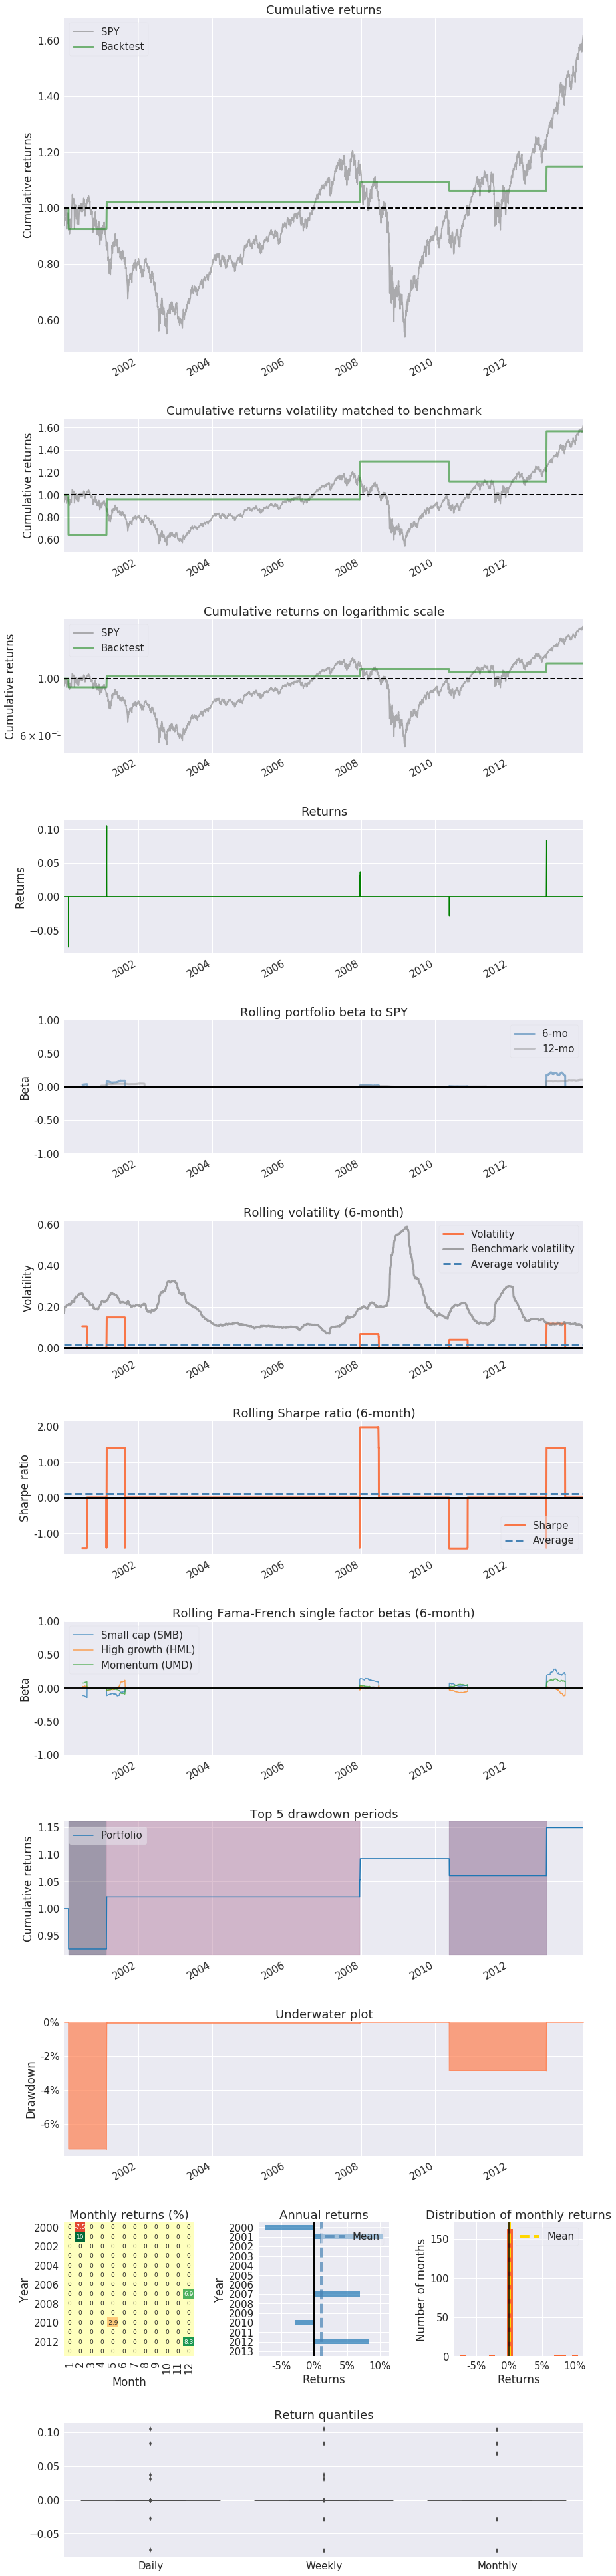

Stress Events,mean,min,max
Dotcom,0.00%,0.00%,0.00%
Lehmann,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,0.00%,0.00%,0.00%
Aug07,0.00%,0.00%,0.00%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


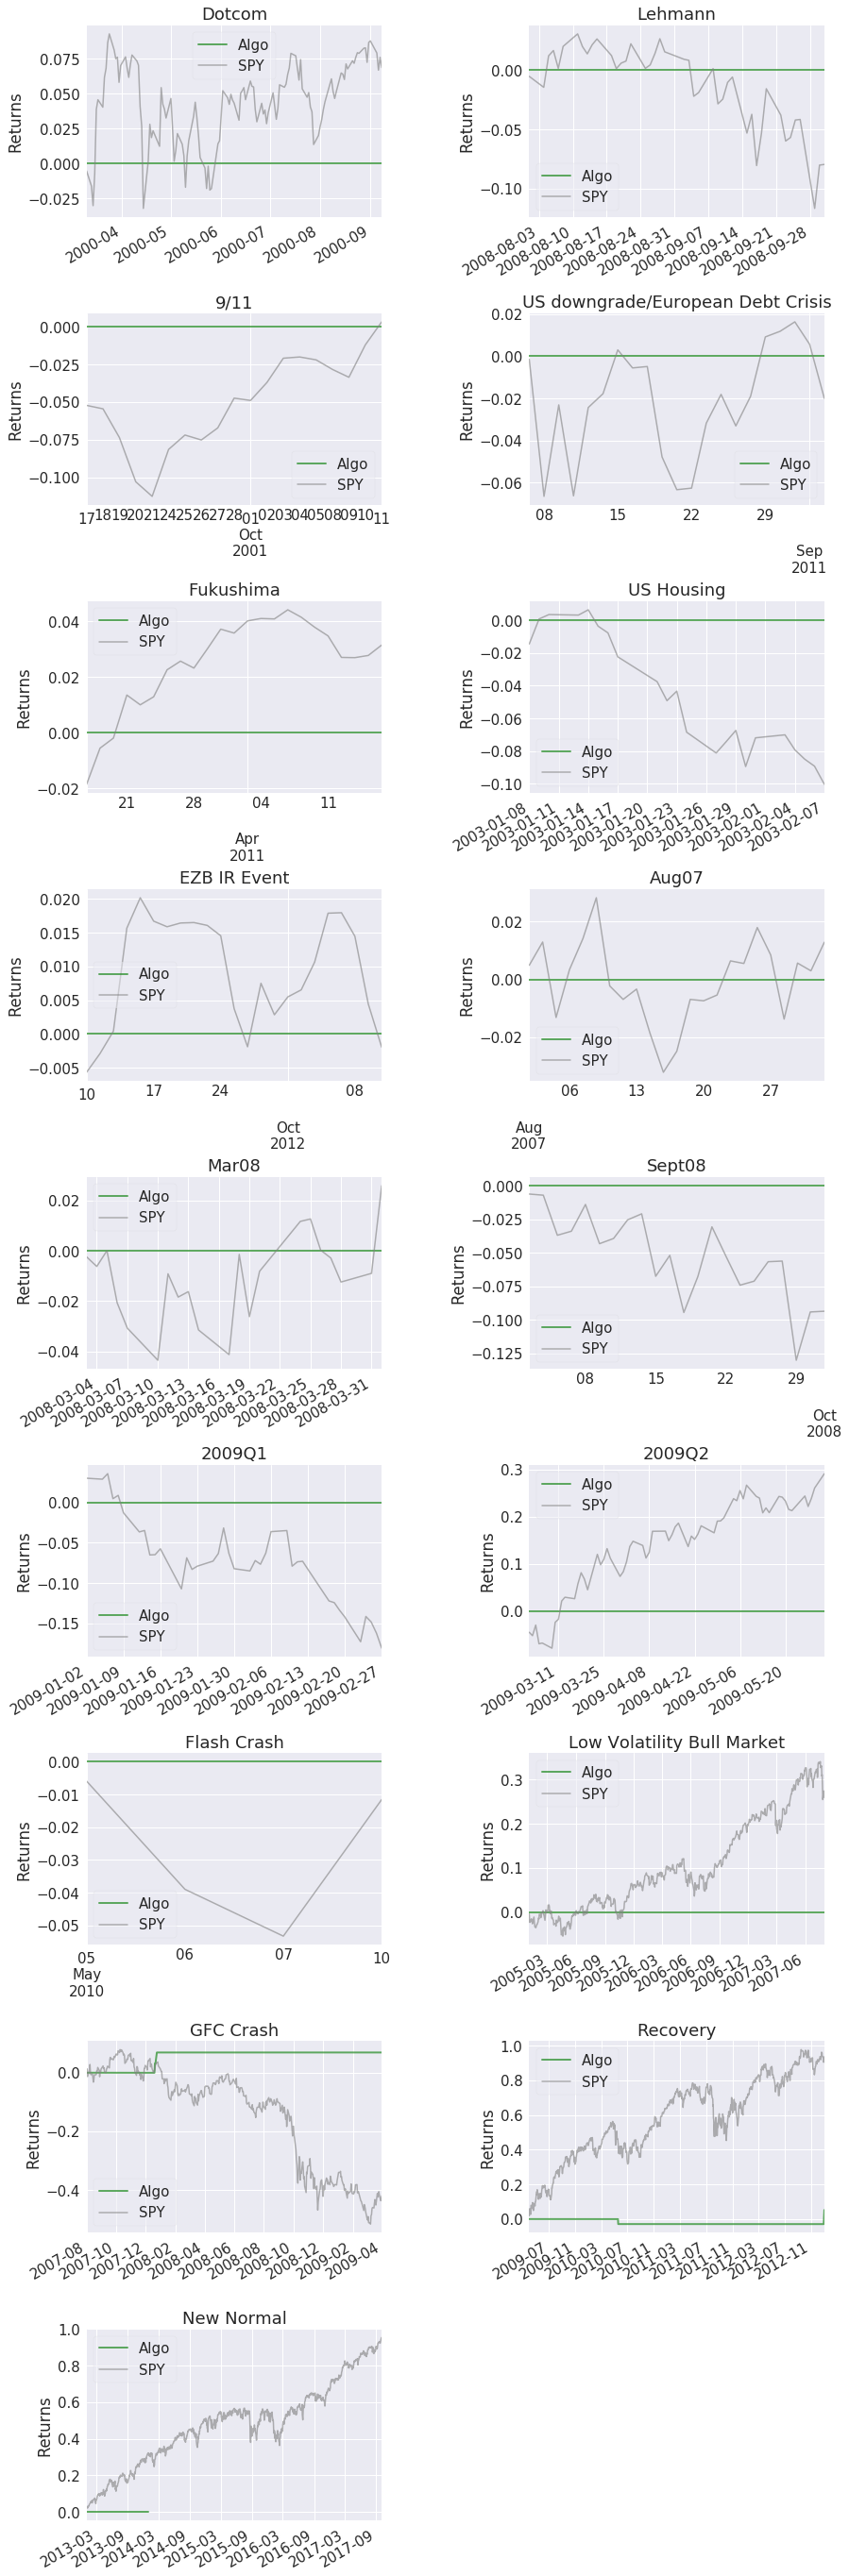

Top 10 long positions of all time,max
SPY,505.20%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SPY,505.20%


All positions ever held,max
SPY,505.20%


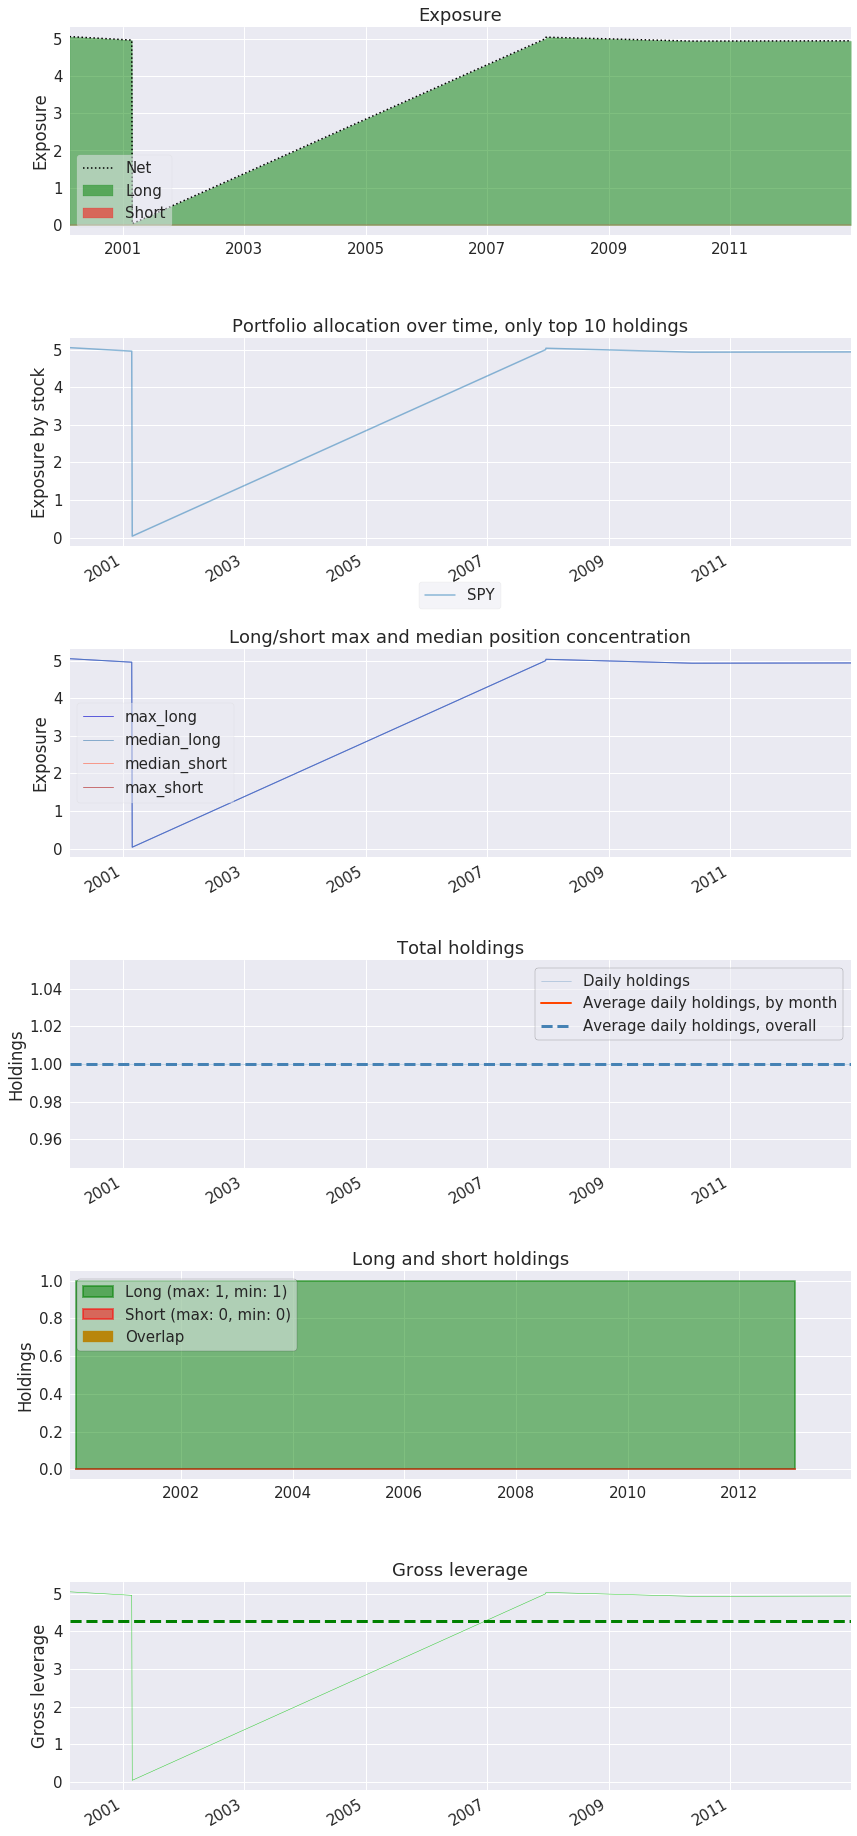

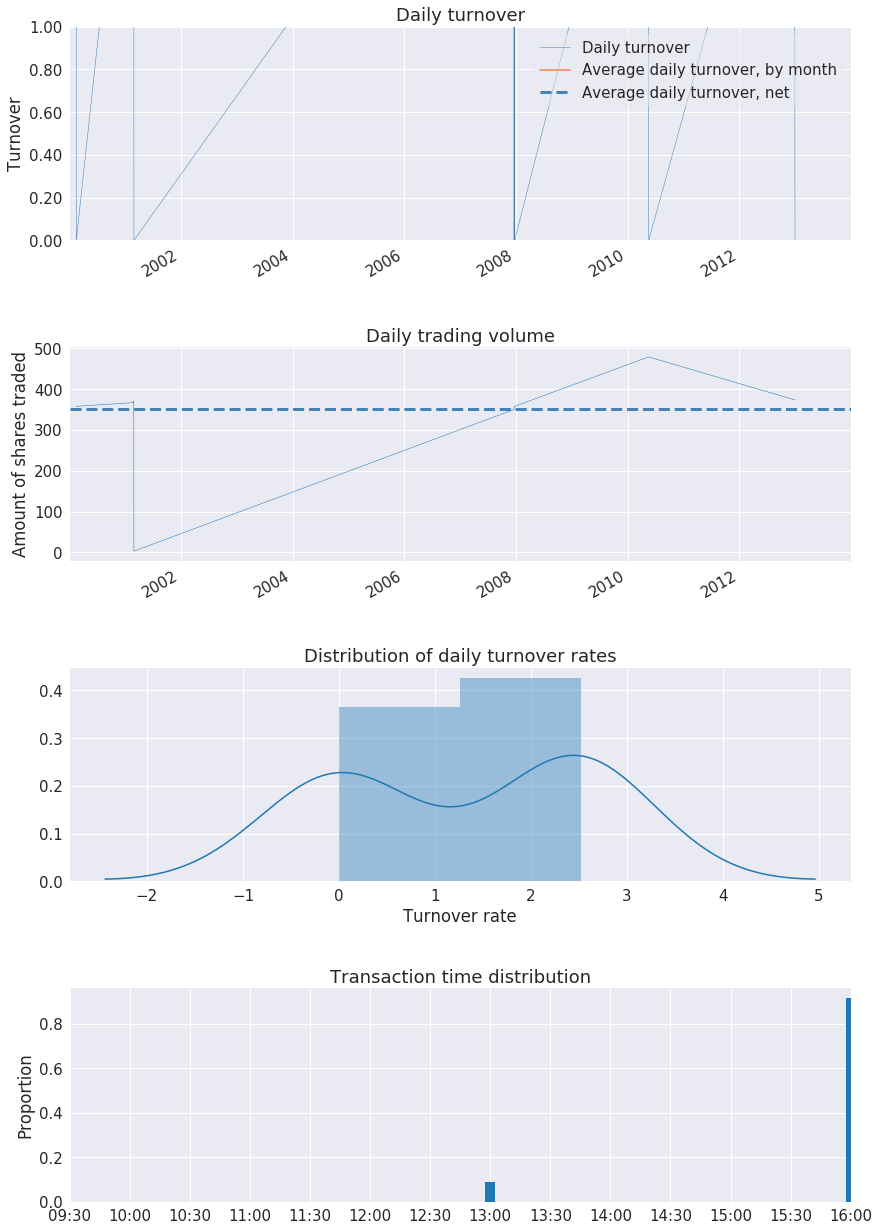

/usr/local/lib/python3.4/site-packages/pyfolio/round_trips.py:309: RuntimeWarning: divide by zero encountered in double_scalars
  ending_price = ending_val / ending_amount


Summary stats,All trades,Long trades
Total number of round_trips,7.00,7.00
Percent profitable,0.57,0.57
Winning round_trips,4.00,4.00
Losing round_trips,3.00,3.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$1528.08,$1528.08
Gross profit,$2582.14,$2582.14
Gross loss,$-1054.06,$-1054.06
Profit factor,$2.45,$2.45
Avg. trade net profit,$218.30,$218.30
Avg. winning trade,$645.53,$645.53
Avg. losing trade,$-351.35,$-351.35
Ratio Avg. Win:Avg. Loss,$1.84,$1.84
Largest winning trade,$976.22,$976.22
Largest losing trade,$-743.96,$-743.96


Duration stats,All trades,Long trades
Avg duration,1 days 20:08:34.285714,1 days 20:08:34.285714
Median duration,1 days 00:00:00,1 days 00:00:00
Longest duration,3 days 00:00:00,3 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,10.56%,10.56%
Avg returns winning,10.56%,10.56%
Avg returns losing,nan%,nan%
Median returns all round_trips,10.56%,10.56%
Median returns winning,10.56%,10.56%
Median returns losing,nan%,nan%
Largest winning trade,10.56%,10.56%
Largest losing trade,10.56%,10.56%


Symbol stats,SPY
Avg returns all round_trips,10.56%
Avg returns winning,10.56%
Avg returns losing,nan%
Median returns all round_trips,10.56%
Median returns winning,10.56%
Median returns losing,nan%
Largest winning trade,10.56%
Largest losing trade,10.56%


Profitability (PnL / PnL total) per name,
SPY,100.00%


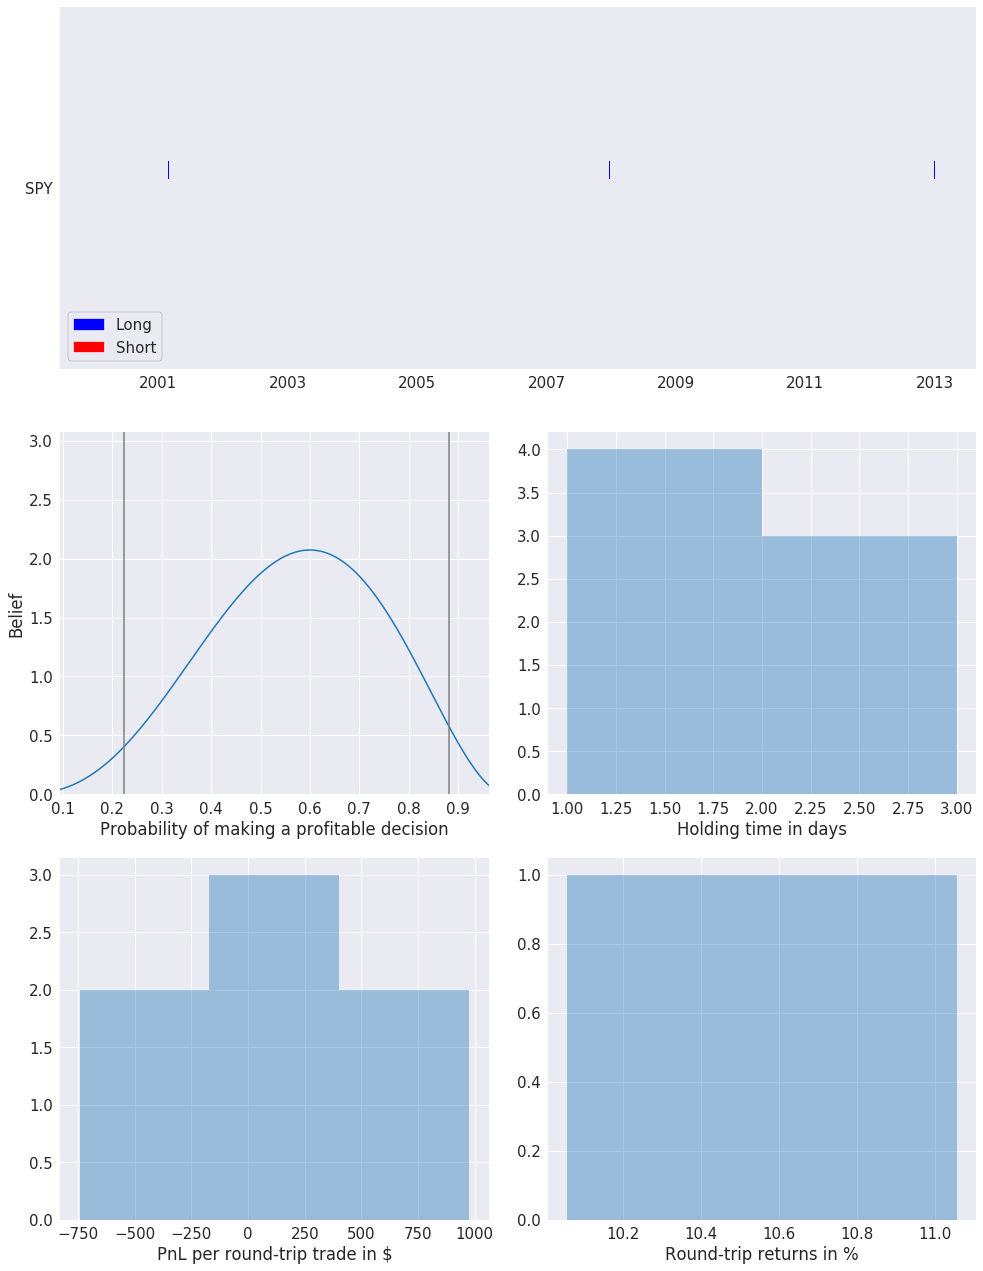

In [15]:
pf.create_full_tear_sheet(returns, positions, transactions, round_trips=True)